# **Soil Type Classification - Competition Submission**
This notebook presents a solution for the soil classification task. It uses a Convolutional Neural Network (CNN) to classify images of soil into four categories: Alluvial, Black, Clay, and Red soil.


#### Install necessary libraries


In [1]:
!pip install tensorflow pandas scikit-learn opencv-python


#### Define paths and Extract zip file



In [2]:
import zipfile

zip_path = "/content/soil-classification.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


#### Check extracted contents


In [6]:
print(os.listdir("/content/soil_classification-2025"))


['test', 'sample_submission.csv', 'test_ids.csv', 'train_labels.csv', 'train']


In [4]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


####Preprocessing

In [7]:
IMG_SIZE = 224
base_path = "soil_classification-2025"
train_dir = os.path.join(base_path, "train")
test_dir = os.path.join(base_path, "test")

# Load training labels
labels_df = pd.read_csv(os.path.join(base_path, "train_labels.csv"))

# Encode soil types
le = LabelEncoder()
labels_df['label'] = le.fit_transform(labels_df['soil_type'])  # 0 to 3


In [8]:
def preprocess_image(img_path, size=IMG_SIZE):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, (size, size))
    img = img / 255.0  # normalize
    return img


####**Prepare Data** - 1) Load training images



In [9]:
X, y = [], []

for _, row in labels_df.iterrows():
    image_id = row['image_id']
    label = row['label']
    img_path = os.path.join(train_dir, image_id)
    img = preprocess_image(img_path)
    if img is not None:
        X.append(img)
        y.append(label)

X = np.array(X)
y = to_categorical(y, num_classes=4)  # one-hot encoding


#### 2) Split into train and validation sets


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


####**Model Architecture** - Define CNN model


In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

#### **Train the Model**

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks for better training
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1
)

# Train with callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9617 - loss: 0.1093
Epoch 1: val_accuracy improved from -inf to 0.89388, saving model to best_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.9616 - loss: 0.1098 - val_accuracy: 0.8939 - val_loss: 0.3143 - learning_rate: 0.0010
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9648 - loss: 0.1359
Epoch 2: val_accuracy improved from 0.89388 to 0.91837, saving model to best_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.9648 - loss: 0.1355 - val_accuracy: 0.9184 - val_loss: 0.2581 - learning_rate: 0.0010
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9756 - loss: 0.0826
Epoch 3: val_accuracy improved from 0.91837 to 0.97143, saving model to best_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9757 - loss: 0.0827 - val_accuracy: 0.9714 - val_loss: 0.1908 - learning_rate: 0.0010
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9758 - loss: 0.0712
Epoch 4: val_accuracy did not improve from 0.97143
31/31 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.9757 - loss: 0.0714 - val_accuracy: 0.9429 - val_loss: 0.2478 - learning_rate: 0.0010
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9696 - loss: 0.0841
Epoch 5: val_accuracy did not improve from 0.97143
31/31 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.9696 - loss: 0.0842 - val_accuracy: 0.9592 - val_loss: 0.2038 - learning_rate: 0.0010
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9863 - loss: 0.0453
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_accuracy did not improve from 0.97143
31/31 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.9861 - loss: 0.0458 - val_accuracy: 0.9633 - va

####**Evaluate the Model** - 1) Plot accuracy and loss


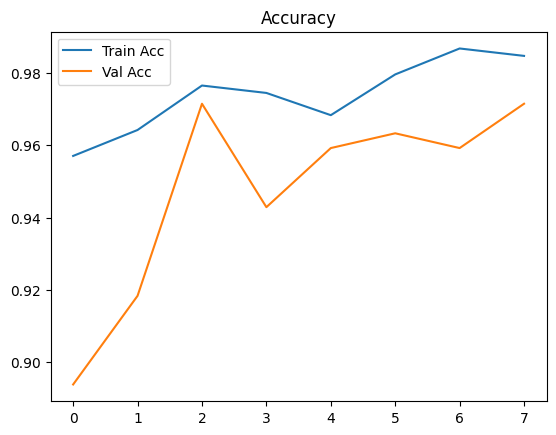

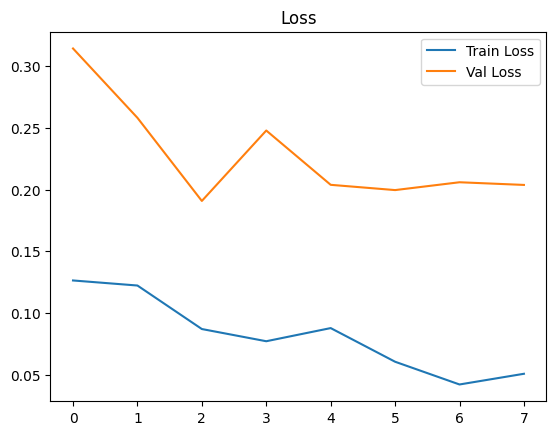

In [23]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()


#### 2) Evaluate with classification report
#### 3) Report the weakest performing class


In [24]:
from sklearn.metrics import classification_report, f1_score

val_preds = model.predict(X_val)
val_preds_classes = np.argmax(val_preds, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

print("Classification Report:\n")
print(classification_report(y_val_classes, val_preds_classes, target_names=le.classes_))

f1_per_class = f1_score(y_val_classes, val_preds_classes, average=None)
min_f1 = np.min(f1_per_class)
print(f"\n📊 Minimum F1-score across classes: {min_f1:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 744ms/step
Classification Report:

               precision    recall  f1-score   support

Alluvial soil       0.97      0.97      0.97       106
   Black Soil       0.98      0.93      0.96        46
    Clay soil       0.93      0.97      0.95        40
     Red soil       1.00      1.00      1.00        53

     accuracy                           0.97       245
    macro avg       0.97      0.97      0.97       245
 weighted avg       0.97      0.97      0.97       245


📊 Minimum F1-score across classes: 0.9512


#### **Test Prediction & Submission File**

In [28]:
test_ids = pd.read_csv(os.path.join(base_path, "test_ids.csv"))

X_test = []
test_filenames = []

for image_id in test_ids['image_id']:
    img_path = os.path.join(test_dir, image_id)
    img = preprocess_image(img_path)
    if img is not None:
        X_test.append(img)
        test_filenames.append(image_id)

X_test = np.array(X_test)


In [29]:
pred_probs = model.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)
pred_labels = le.inverse_transform(pred_classes)


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 866ms/step


In [32]:
submission_df = pd.DataFrame({
    'image_id': test_filenames,
    'soil_type': pred_labels
})

submission_df.to_csv("submission2.csv", index=False)


#### **Conclusion**
This notebook builds and evaluates a CNN model to classify soil images into four categories. The final submission is written to `submission.csv` in the required format. All preprocessing, training, and prediction steps are documented for reproducibility.
